# Multi-Layer Perceptron, MNIST

### import libraries

In [1]:
import torch
import numpy as np

from tqdm import tqdm


## Load and Visualize the Data

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
## TODO: set number of samples per batch to load
batch_size = 64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Visualize a Batch of Training Data

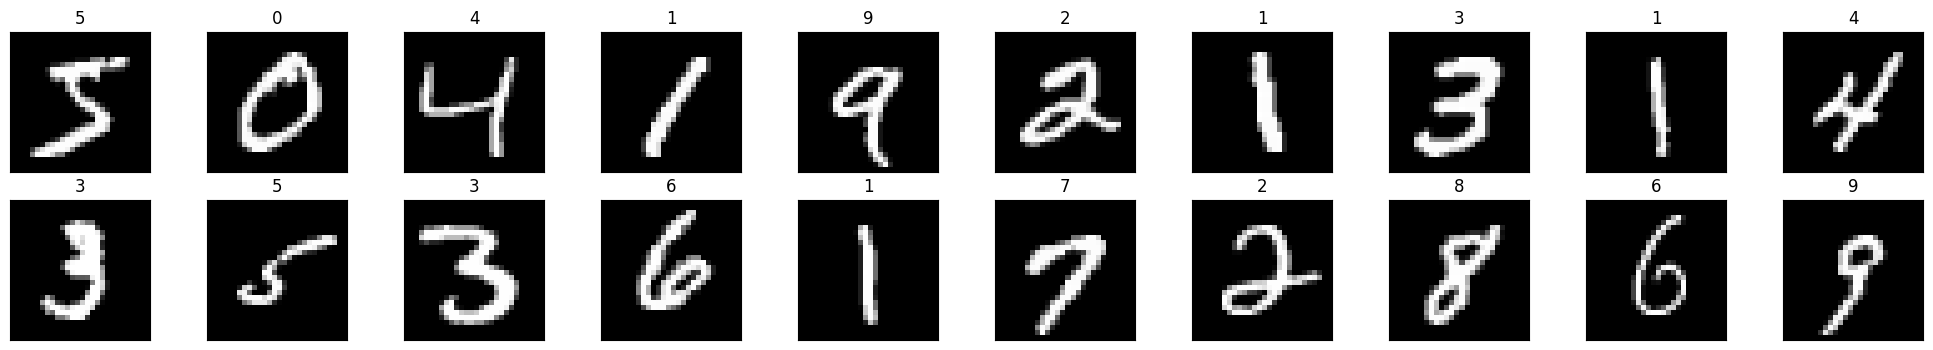

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))


### View an Image in More Detail

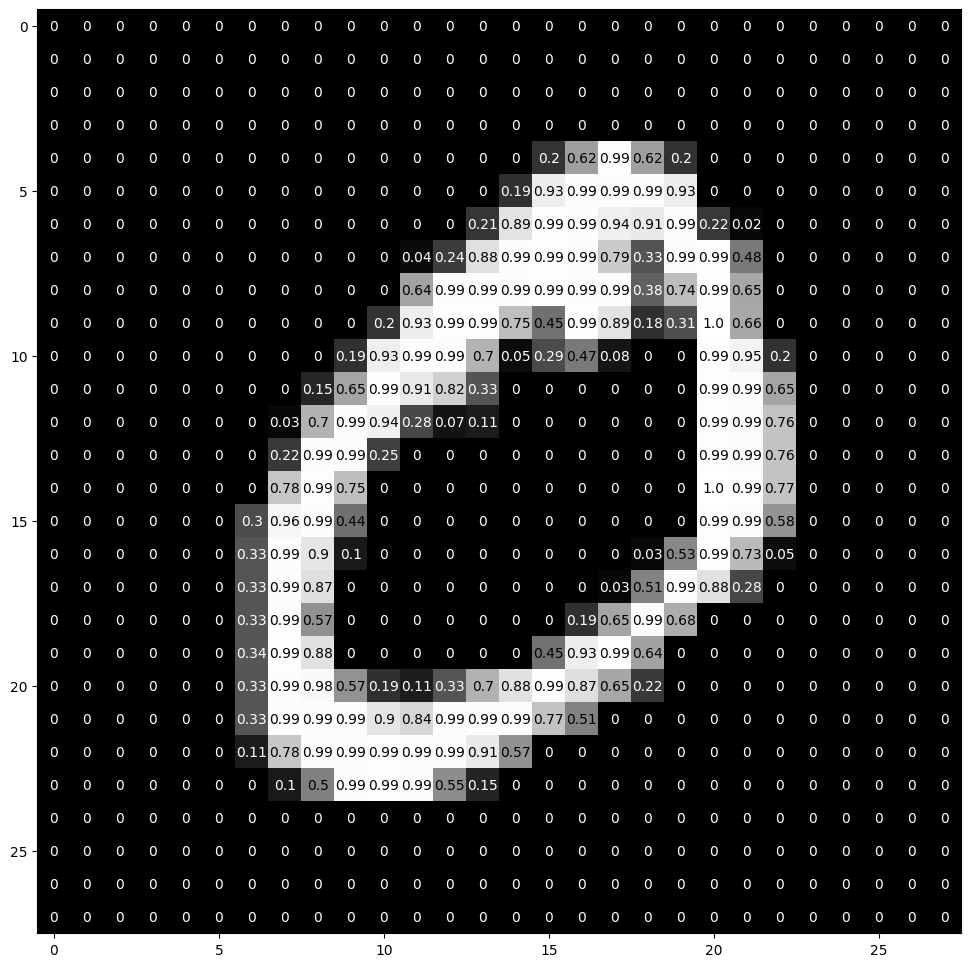

In [4]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')


## Define the Network Architecture

In [5]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: Define the NN architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.relu1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.relu1(x)
        #x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        #x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [6]:
# initialize the NN
model = Net()
_ = model.to(device)
print(device)
print(model)

cuda
Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)


In [7]:
## TODO: specify loss function
criterion = nn.CrossEntropyLoss()

## TODO: specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



## Train the Network


In [8]:
## TODO:
###############################################
#               train the model               #
###############################################

# Set the number of epochs to train for
n_epochs = 10
ls_loss = []
# Train the model
for epoch in tqdm(range(n_epochs)):
    # Set the model to training mode
    model.train()
    
    # Iterate over the training data
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        
        # Forward pass
        output = model(data)
        
        # Calculate the loss
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the training loss
        ls_loss.append(loss.item())
    
    # Print the training loss for the epoch
    # print('Epoch: {} \tTraining Loss: {:.6f}'.format(
    #     epoch+1, 
    #     ls_loss[-1]
    #     ))


100%|██████████| 10/10 [01:06<00:00,  6.61s/it]


## Predict with Trained Network



In [9]:
###############################################
#               test the model                #
###############################################
y_pred, y_test = [], []

model.eval()
with torch.no_grad():
    # Initialize variables to keep track of accuracy and loss
    test_loss = 0.0
    correct = 0
    total = 0
    # Iterate over the test data
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        y_test += target.detach().cpu().numpy().tolist()
        
        # Forward pass
        output = model(data)
        y_pred += output.detach().cpu().numpy().tolist()
        
        # Calculate the loss
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        
        # Get the predicted class for each image in the batch
        _, predicted = torch.max(output.data, 1)
        
        # Update the total number of images
        total += target.size(0)
        
        # Update the number of correct predictions
        correct += (predicted == target).sum().item()

    # Calculate the average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100.0 * correct / total

    # Print the results
    print('Test Loss: {:.6f}\tTest Accuracy: {:.2f}%'.format(
        avg_test_loss, 
        accuracy
    ))


Test Loss: 0.084713	Test Accuracy: 98.10%


### Visualize Sample Test Results

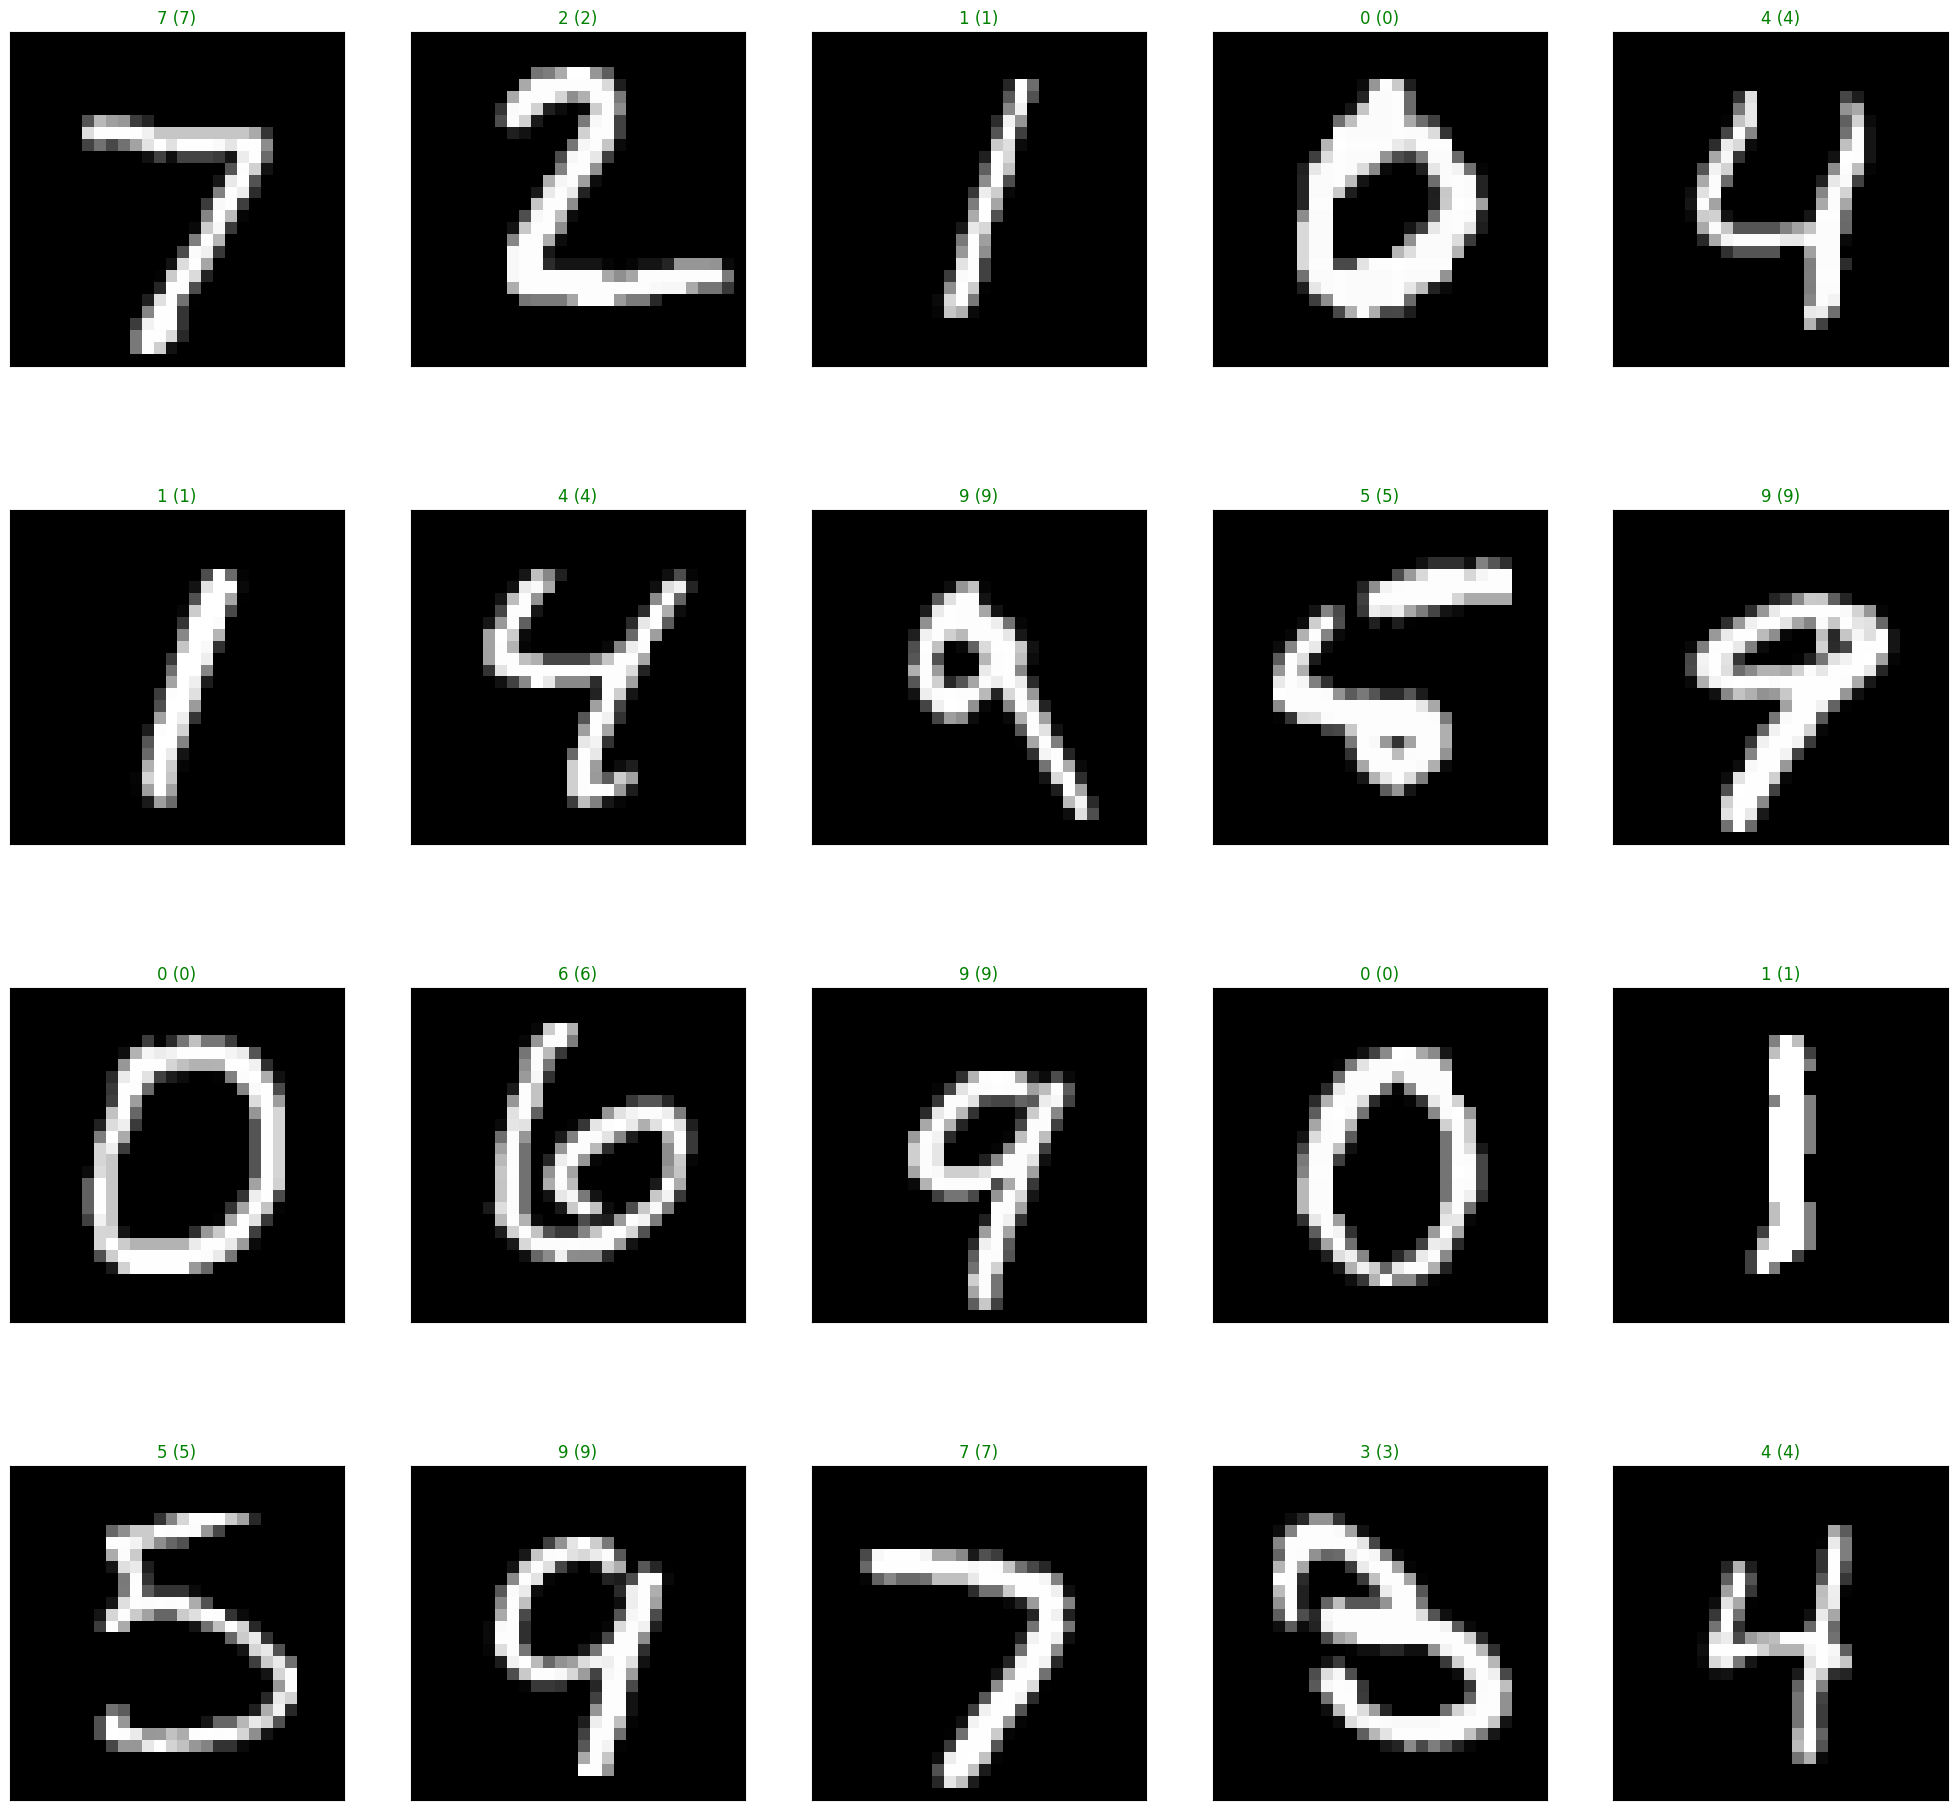

In [10]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 30))
for idx in np.arange(20):
    ax = fig.add_subplot(5, 20//4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## evaluation metrics

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_curve, auc

#### Calculate Accuracy

In [12]:
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.981


#### Making the Confusion Matrix

In [13]:
confusion = confusion_matrix(y_test, y_pred)
print('confusion matrix:')
print(confusion)

confusion matrix:
[[ 972    1    1    0    0    2    1    2    1    0]
 [   0 1128    1    0    0    0    2    0    4    0]
 [   3    1 1018    1    2    0    0    5    2    0]
 [   1    0    6  970    0    8    0    5    2   18]
 [   2    0    1    0  956    0    3    2    1   17]
 [   2    0    0    4    1  879    1    1    2    2]
 [   2    2    0    0    4    6  943    1    0    0]
 [   2    3    9    0    1    1    0 1004    2    6]
 [   5    1    3    2    1    7    2    2  947    4]
 [   0    2    0    0    6    4    1    2    1  993]]


#### Calculate the f1_score for each class

In [14]:
f1_score_list = f1_score(y_test, y_pred, average=None)

for i, f1_score in enumerate(f1_score_list):
    print('f1_score for class {} is: {}'.format(i, f1_score))

f1_score for class 0 is: 0.9873031995937024
f1_score for class 1 is: 0.9925208974923009
f1_score for class 2 is: 0.9830999517141478
f1_score for class 3 is: 0.9763462506290891
f1_score for class 4 is: 0.9790066564260111
f1_score for class 5 is: 0.9772095608671484
f1_score for class 6 is: 0.9869178440607012
f1_score for class 7 is: 0.9785575048732943
f1_score for class 8 is: 0.9783057851239669
f1_score for class 9 is: 0.9692532942898975


### Calculate the AUC and ROC

In [15]:
import pandas as pd

y_score = []
for x in y_pred:
    temp = [0]*10
    temp[x] = 1
    y_score.append(temp)
y_score_df = pd.DataFrame(y_score)
y_score_df= y_score_df.fillna(0)
y_score = y_score_df.to_numpy()
print(y_score)

[[0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


##### Calculate the AUC and ROC for each class

In [16]:
from sklearn.preprocessing import label_binarize

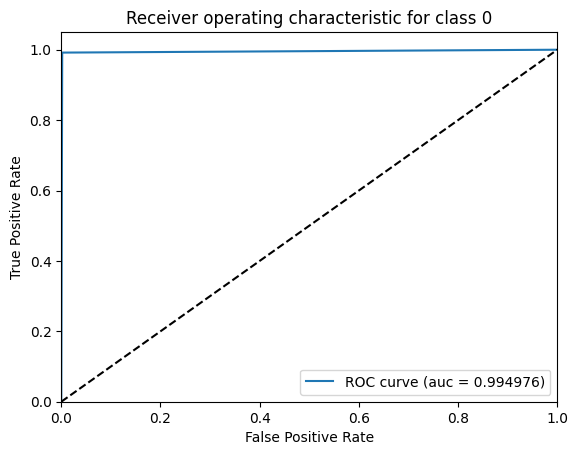

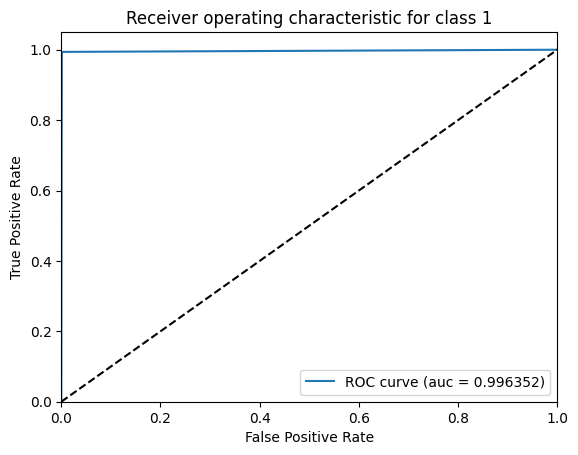

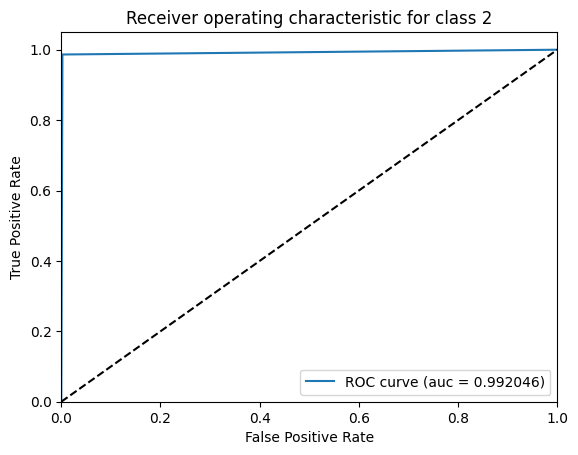

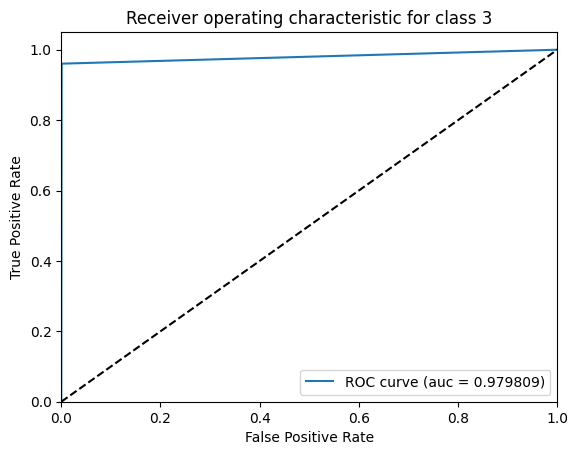

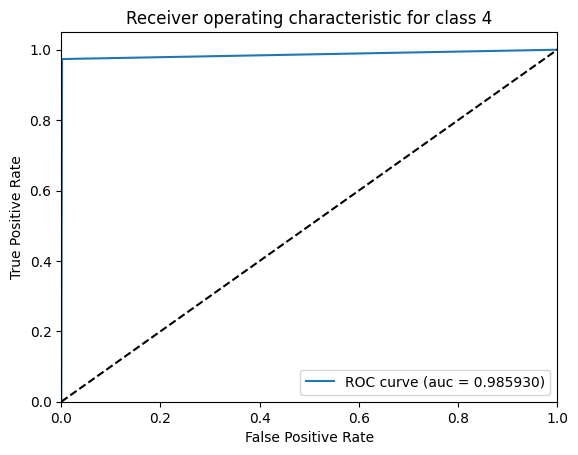

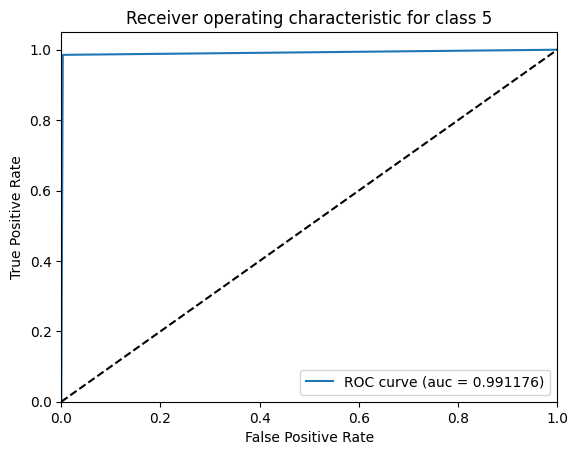

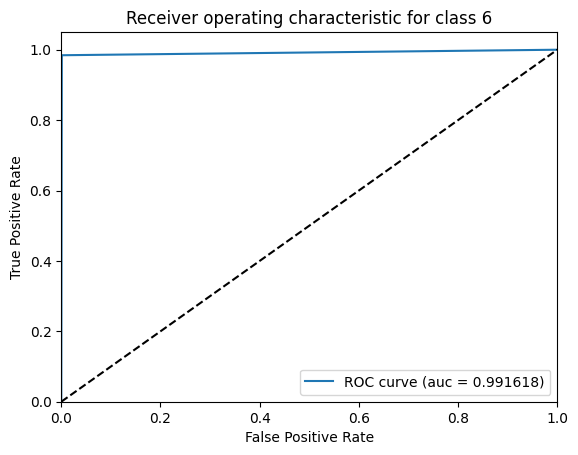

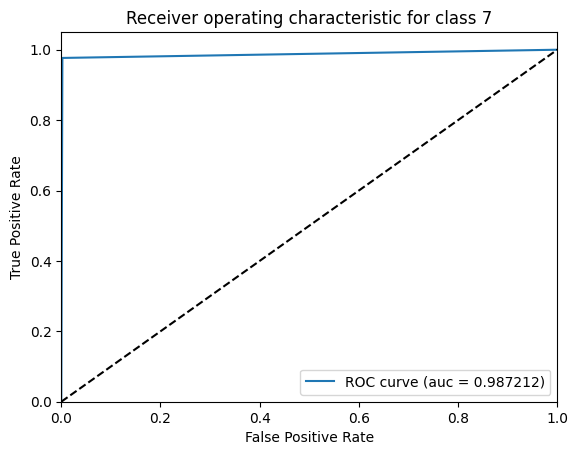

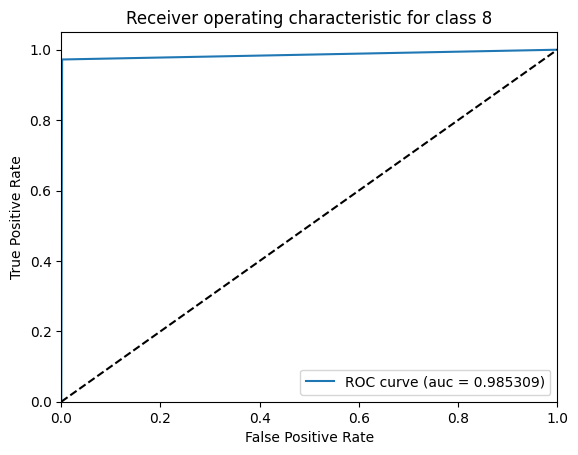

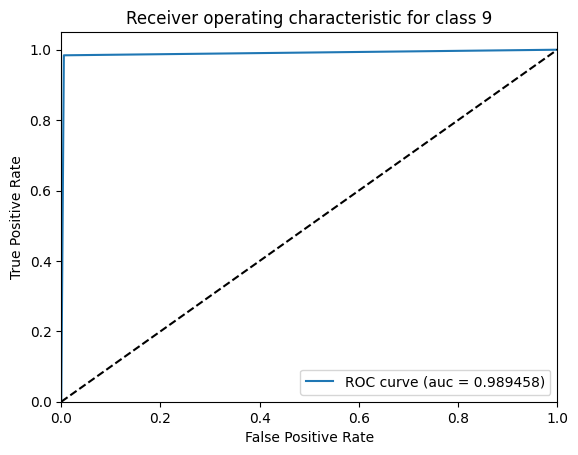

In [17]:
n_classes = 10
y_test_binery = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binery[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (auc = %0.6f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

##### Calculate the AUC and ROC average

In [18]:
from scipy import interp

/tmp/ipykernel_4164/2285847025.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


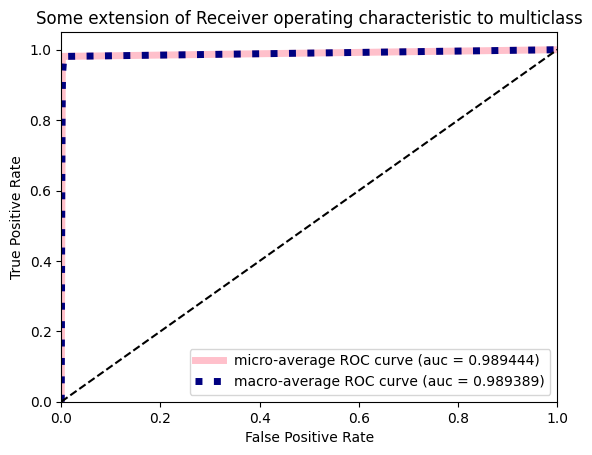

In [19]:
# First aggregate all false positive rates
n_classes = 10
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binery.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (auc = {0:0.6f})".format(roc_auc["micro"]),
    color="pink",
    linewidth=5,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (auc = {0:0.6f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=5,
)

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()
